# **1 - Perkenalan**

---



Bab pengenalan harus diisi dengan identitas, gambaran besar dataset yang digunakan, dan objective yang ingin dicapai.

Name : Andik Al Fauzi

Batch : FTDS-RMT-018

Dataset : [Sample Dataset Time Series](https://raw.githubusercontent.com/andik-alfauzi/Final-Project/main/sample_dataset_timeseries_noarea.csv)

Objective : Membuat model prediksi total penjualan untuk 4 pekan selanjutnya dimulai dari tanggal 2023-04-10 dan pekan-pekan selanjutnya.

# **2 - Import Libraries**

---



Cell pertama pada notebook harus berisi dan hanya berisi semua library yang digunakan dalam project.

In [491]:
# Importing libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Model Libraries
from sklearn.svm import SVR
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import statsmodels.api as sm
from math import sqrt
import calendar

# Visualization libraries
import matplotlib
import matplotlib.pyplot as plt

# Model Preprocessing libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Importing Libraries
import pickle
import json

# Warning Library
import warnings
warnings.filterwarnings('ignore')

In [492]:
!pip install pyramid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **3 - Data Loading**

---



Bagian ini berisi proses penyiapan data sebelum dilakukan eksplorasi data lebih lanjut. Proses Data Loading dapat berupa memberi nama baru untuk setiap kolom, mengecek ukuran dataset, dll.

In [493]:
# Load the data
data = pd.read_csv('https://raw.githubusercontent.com/andik-alfauzi/Final-Project/main/sample_dataset_timeseries_noarea.csv')

Data yang diloading sesuai dengan instruksi disimpan didalam variable data

In [494]:
# Copy the data make sure the original is untouchable
copyData = data.copy()

# Display Dataframe
copyData

,week_number,week_start_date,week_end_date,product_item,quantity
0,2021-52,2021-12-27,2022-01-02,0073377087c7ddace313ff829cd7b0b3,41
1,2021-52,2021-12-27,2022-01-02,012d2bb142b2d5e57330acbfd8e9ac52,430
2,2021-52,2021-12-27,2022-01-02,0192926e33d1153b63511a5b83eca843,4
3,2021-52,2021-12-27,2022-01-02,019502f6d13e383caa9b9673bf1302f8,148
4,2021-52,2021-12-27,2022-01-02,01e7ca6d4e21badc1d4225b6b2c7bd9e,119
...,...,...,...,...,...
102728,2023-14,2023-04-03,2023-04-09,ff3890faa80ff425ae906e27bbc50bc6,907
102729,2023-14,2023-04-03,2023-04-09,ff4b0f3b9c78c91510a4e3920fbc5090,81
102730,2023-14,2023-04-03,2023-04-09,ff9d05a4d6f922b3ab1653f58165b8ce,16
102731,2023-14,2023-04-03,2023-04-09,ffbd6f1d884056a4f622d54ae79e5a14,42920


Dataset original dicopy agar data original dapat dipakai ketika ada masalah nantinya

# **4 - Exploratory Data Analysis (EDA)**

---

Bagian ini berisi eksplorasi data pada dataset diatas dengan menggunakan query, grouping, visualisasi sederhana, dan lain sebagainya.



In [495]:
# Check data info
copyData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102733 entries, 0 to 102732
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   week_number      102733 non-null  object
 1   week_start_date  102733 non-null  object
 2   week_end_date    102733 non-null  object
 3   product_item     102731 non-null  object
 4   quantity         102733 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 3.9+ MB


Dataset berjumlah 102733 baris dengan 5 kolom. Terlihat ada missing value di data `product_item` sejumlah 2 data

In [496]:
# Decribing data
copyData.describe()

,quantity
count,102733.000000
mean,3191.562419
std,12074.631014
min,0.000000
25%,75.000000
50%,414.000000
75%,1890.000000
max,774732.000000


Dataset cenderung skew, karena dapat dilihat antara nilai mean dengan max memiliki gap yang cukup besar.

In [497]:
# Check null sales quantity
copyData.loc[(copyData['quantity'] == 0)]

,week_number,week_start_date,week_end_date,product_item,quantity
72589,2022-47,2022-11-21,2022-11-27,6adc4ddabd44c5aa2f4c6105ceda926a,0
74199,2022-48,2022-11-28,2022-12-04,6adc4ddabd44c5aa2f4c6105ceda926a,0
75806,2022-49,2022-12-05,2022-12-11,6adc4ddabd44c5aa2f4c6105ceda926a,0


Berikut adalah product_item yang tidak memiliki penjualan pada tanggal 2022-11-21 sampai 2022-12-05

In [498]:
# Check duplicated data
print('Data duplicated : {}'.format(copyData.duplicated().sum()))

Data duplicated : 0


Tidak ada data duplicate

In [499]:
# Change into datetime
copyData['week_start_date'] = pd.to_datetime(copyData['week_start_date'], format='%Y-%m-%d')

Berikut saya rubah format tanggal dari data `week_start_date` dari tipe object menjadi datetime

In [500]:
# Get the dataframe
sales = copyData.groupby('week_start_date')['quantity'].sum()

# Display
sales

week_start_date
2021-12-27     128808
2022-01-03    3839557
2022-01-10    4138934
2022-01-17    4149077
2022-01-24    4824273
               ...   
2023-03-06    4775638
2023-03-13    4787111
2023-03-20    4757590
2023-03-27    6001166
2023-04-03    4172070
Name: quantity, Length: 67, dtype: int64

Dataframe yang akan digunakan adalah mengelompokan per tanggal di kolom `week_start_date` dengan total `quantity` pada tanggal tersebut

<Axes: xlabel='week_start_date'>

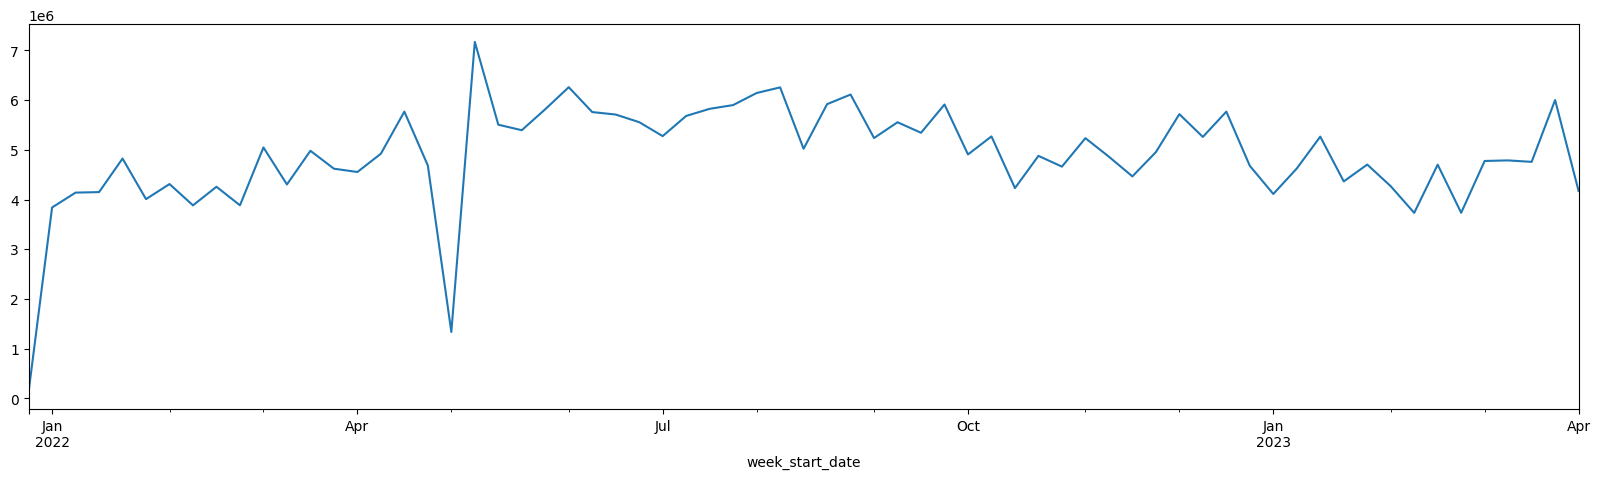

In [501]:
# Trend Visualization

sales.plot(figsize=(20,5))

Dari visualisasi diatas dapat dilihat data penjualan tidak memiliki trend yang beragam, ada kenaikan di masing-masing pekan dalam bulan tersebut dan juga terlihat adanya penurunan dibanding pekan tersebut pula. Penjualan terendah ada pada awal pekan May-2022, yang terlihat grafik penurunannya sangat tajam namun kembali naik pada pekan selanjutnya.

# **5 - Data Preprocessing**

---

Bagian ini berisi proses penyiapan data untuk proses pelatihan model, seperti pembagian data menjadi train-test, transformasi data (normalisasi, encoding, dll.), dan proses-proses lain yang dibutuhkan.

## 5.1 Window

In [502]:
# Create A New Dataset with `window=4`

window = 4
X = []
y = []

for index in range(0, len(sales)-window):
  X.append(sales[index : window + index])
  y.append(sales[window + index])

X = np.array(X)
y = np.array(y)

# Display
print('Data X : ')
print(X, X.shape)
print('='*100)
print('Data y : ')
print(y, y.shape)

Data X : 
[[ 128808 3839557 4138934 4149077]
 [3839557 4138934 4149077 4824273]
 [4138934 4149077 4824273 4008027]
 [4149077 4824273 4008027 4311010]
 [4824273 4008027 4311010 3882636]
 [4008027 4311010 3882636 4256541]
 [4311010 3882636 4256541 3883810]
 [3882636 4256541 3883810 5047898]
 [4256541 3883810 5047898 4303200]
 [3883810 5047898 4303200 4980880]
 [5047898 4303200 4980880 4620355]
 [4303200 4980880 4620355 4553719]
 [4980880 4620355 4553719 4921338]
 [4620355 4553719 4921338 5768747]
 [4553719 4921338 5768747 4684319]
 [4921338 5768747 4684319 1334134]
 [5768747 4684319 1334134 7172144]
 [4684319 1334134 7172144 5505616]
 [1334134 7172144 5505616 5394786]
 [7172144 5505616 5394786 5817233]
 [5505616 5394786 5817233 6260083]
 [5394786 5817233 6260083 5759699]
 [5817233 6260083 5759699 5709933]
 [6260083 5759699 5709933 5556481]
 [5759699 5709933 5556481 5275889]
 [5709933 5556481 5275889 5682207]
 [5556481 5275889 5682207 5824993]
 [5275889 5682207 5824993 5900392]
 [5682207 

Bagan ini saya menggunakan window = 4 karena saya berasumsi ingin melihat penjualan pada 4 pekan bulan selanjutnya

In [503]:
# Combines `X` and `y` into DataFrame
X_y_df = pd.concat([pd.DataFrame(X, columns=['X0', 'X1', 'X2', 'X3']), pd.DataFrame(y, columns=['y'])], axis=1)
X_y_df

,X0,X1,X2,X3,y
0,128808,3839557,4138934,4149077,4824273
1,3839557,4138934,4149077,4824273,4008027
2,4138934,4149077,4824273,4008027,4311010
3,4149077,4824273,4008027,4311010,3882636
4,4824273,4008027,4311010,3882636,4256541
...,...,...,...,...,...
58,4267946,3731588,4701262,3732954,4775638
59,3731588,4701262,3732954,4775638,4787111
60,4701262,3732954,4775638,4787111,4757590
61,3732954,4775638,4787111,4757590,6001166


## 5.2 Split Dataset

In [504]:
# Splitting Dataset
train_size = round(len(X)*0.8)

X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

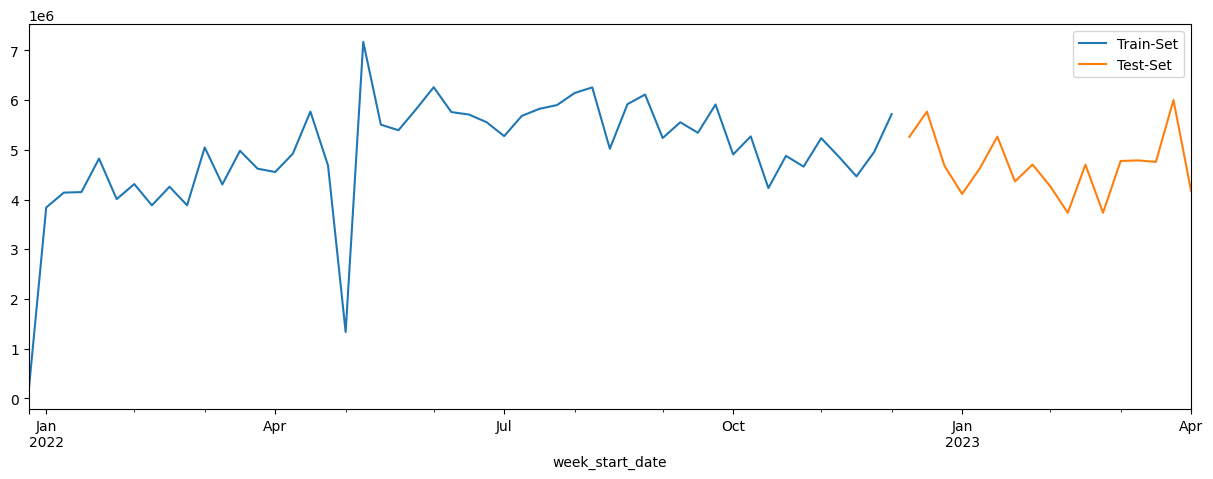

In [505]:
# Trend Visualization of train-set and test-set
sales[:train_size].plot.line(figsize=(15, 5))
sales[train_size:].plot.line(figsize=(15,5))
plt.legend(['Train-Set', 'Test-Set'])

## 5.3 Scaling

In [506]:
# Scaling using MinMaxScaler
scaler = MinMaxScaler()

X_trainScaled = scaler.fit_transform(X_train)
X_testScaled = scaler.transform(X_test)

# **6 - Model**

---

Bagian ini berisi cell untuk mendefinisikan model. Jelaskan alasan menggunakan suatu algoritma/model, hyperparameter yang dipakai, jenis penggunaan metrics yang dipakai, dan hal lain yang terkait dengan model.

##6.1 Linear Regression

In [507]:
# Define Linear Regression 
%%time
LRModel = LinearRegression(fit_intercept = True, n_jobs=1)
LRModel.fit(X_trainScaled, y_train)

# Apply Predict
y_predTrainLR = LRModel.predict(X_trainScaled)
y_predTestLR = LRModel.predict(X_testScaled)

# Check MAE
maeTrainLR = round(mean_absolute_error(y_train, y_predTrainLR),2)
rmseTrainLR = round(sqrt(mean_squared_error(y_train, y_predTrainLR)),2)
maeTestLR = round(mean_absolute_error(y_test, y_predTestLR),2)
rmseTestLR = round(sqrt(mean_squared_error(y_test, y_predTestLR)),2)
print('Train - MAE - Linear Regression  : ', maeTrainLR)
print('Train - RMSE - Linear Regression  : ', rmseTrainLR)
print('Test - MAE - Linear Regression   : ', maeTestLR)
print('Test - RMSE - Linear Regression  : ', rmseTestLR)

Train - MAE - Linear Regression  :  571645.68
Train - RMSE - Linear Regression  :  809441.77
Test - MAE - Linear Regression   :  529506.77
Test - RMSE - Linear Regression  :  670702.74
CPU times: user 6.43 ms, sys: 0 ns, total: 6.43 ms
Wall time: 6.96 ms


Pada Linear Regression ini saya menggunakan `fit_intercept = True` agar model tetap menghitung nilai bias yang akan merepresentasikan nilai targetnya. Ketika model sudah dilatih dengan data train maka didapat hasil MAE pada data test sebesar **529506.77** dan RMSE pada data test sebesar **670702.74**

In [508]:
# Combine prediction from Linear Regression
y_predLR = np.concatenate([np.array([0, 0, 0, 0]),y_predTrainLR, y_predTestLR], axis=0)

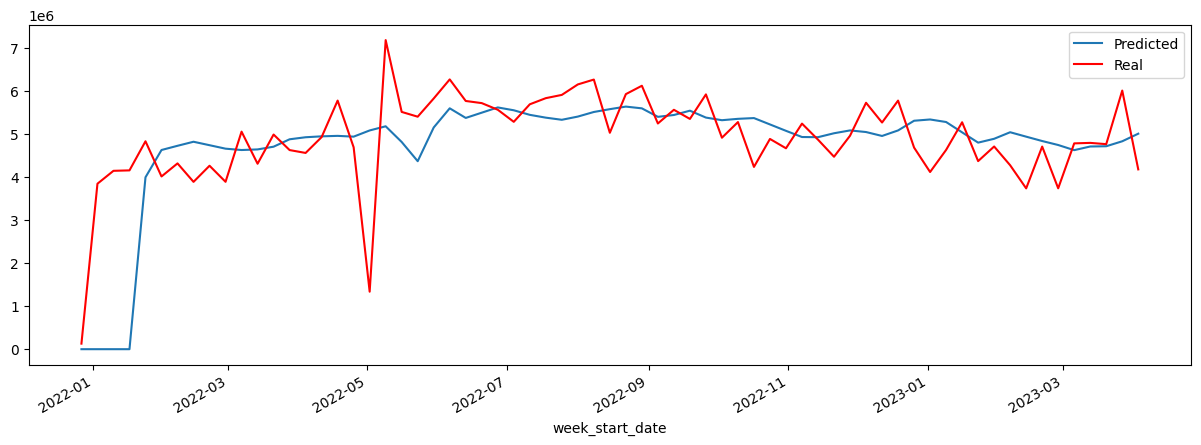

In [509]:
# Trend Visualization between Real Values and Predicted Values

plt.figure(figsize=(15, 5))
plt.plot(sales.index, y_predLR, label='Predicted')
sales.plot(color='red', label='Real')
plt.legend()

Dapat dilihat pada grafik, model Liner ini cenderung tidak dapat merepresentasikan data prediksi secara baik dikarenakan nilai MAE yang didapat masih cukup besar yaitu **529506.77**

## 6.2 Random Forest Regression

In [510]:
# Define Random Forest Regression
%%time
RFModel = RandomForestRegressor(n_estimators=5000, random_state=19, 
                                max_features='sqrt', warm_start = True, 
                                criterion = 'absolute_error')
RFModel.fit(X_trainScaled, y_train)

# Apply Predict
y_predTrainRF = RFModel.predict(X_trainScaled)
y_predTestRF = RFModel.predict(X_testScaled)

# Check MAE
maeTrainRF = round(mean_absolute_error(y_train, y_predTrainRF),2)
rmseTrainRF = round(sqrt(mean_squared_error(y_train, y_predTrainRF)),2)
maeTestRF = round(mean_absolute_error(y_test, y_predTestRF),2)
rmseTestRF = round(sqrt(mean_squared_error(y_test, y_predTestRF)),2)
print('Train - MAE - Random Forest Regression   : ', maeTrainRF)
print('Train - RMSE - Random Forest Regression   : ', rmseTrainRF)
print('Test - MAE - Random Forest Regression    : ', maeTestRF)
print('Test - RMSE - Random Forest Regression   : ', rmseTestRF)

Train - MAE - Random Forest Regression   :  226414.81
Train - RMSE - Random Forest Regression   :  314561.93
Test - MAE - Random Forest Regression    :  571683.24
Test - RMSE - Random Forest Regression   :  727377.79
CPU times: user 12.3 s, sys: 77.5 ms, total: 12.4 s
Wall time: 16.4 s


Pada Model Random Forest saya menggunakan `n_estimators` sebanyak 5000, `max_features` dengan sqrt untuk memilih fitur secara acak pada data, `warm_start` true agar model lebih efisien dalam pelatihan dimana model melanjutkan pelatihan dari inisial terakhir dan `criterion = absolute_error` untuk mengevaluasi model  dengan menggunakan mean_absolute_error. Setelah model  dilatih dengan data train maka didapat nilain MAE pada data test sebesar **571683.24** dan RMSE pada data test sebesar **727377.79**

In [511]:
# Combine prediction from Random Forest
y_predRF = np.concatenate([np.array([0, 0, 0, 0]), y_predTrainRF, y_predTestRF], axis=0)

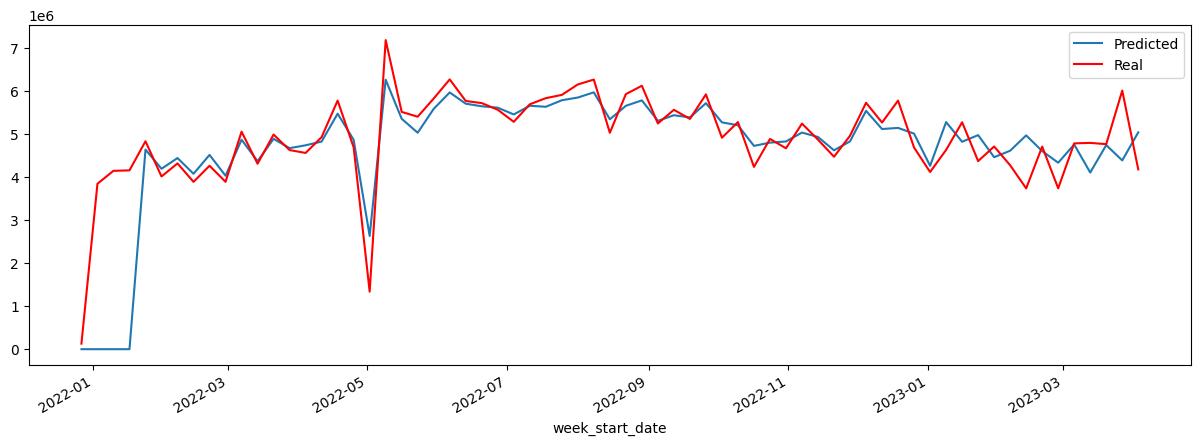

In [512]:
# Trend Visualization between Real Values and Predicted Values

plt.figure(figsize=(15, 5))
plt.plot(sales.index, y_predRF, label='Predicted')
sales.plot(color='red', label='Real')
plt.legend()

Dari grafik diatas dapat dilihat model dapat dengan baik merepresentasikan data prediksi terhadap data aktual dengan baik walaupun masih terdapat selisih dari kedua data tersebut

## 6.3 Support Vector Regression

In [513]:
# Define SVM Regresion
%%time
SVMModel = SVR(kernel = 'poly', degree = 6, C = 1)
SVMModel.fit(X_trainScaled, y_train)

# Apply Predict
y_predTrainSVM = SVMModel.predict(X_trainScaled)
y_predTestSVM = SVMModel.predict(X_testScaled)

# Check MAE
maeTrainSVM = round(mean_absolute_error(y_train, y_predTrainSVM),2)
rmseTrainSVM = round(sqrt(mean_squared_error(y_train, y_predTrainSVM)),2)
maeTestSVM = round(mean_absolute_error(y_test, y_predTestSVM),2)
rmseTestSVM = round(sqrt(mean_squared_error(y_test, y_predTestSVM)),2)
print('Train - MAE - SVR  : ', maeTrainSVM)
print('Train - RMSE - SVR  : ', rmseTrainSVM)
print('Test - MAE - SVR   : ', maeTestSVM)
print('Test - RMSE - SVR  : ', rmseTestSVM)

Train - MAE - SVR  :  420562.73
Train - RMSE - SVR  :  684925.91
Test - MAE - SVR   :  505885.36
Test - RMSE - SVR  :  649890.24
CPU times: user 16.2 ms, sys: 0 ns, total: 16.2 ms
Wall time: 23.2 ms


`kernel = poly` pada SVR kali ini saya gunakan agar model dapat mengubah dimensi fitur awal menjadi dimensi yang lebih tinggi agar dapat semakin kompleks dapat membangun keputusan dengan derajat polynomialnya adalah 6. Nilai C saya inisialisasi agar penentutan trade-off antara kesalahan prediksi dan kompleksitas model. Setelah model dilatih dengan data train maka didapat nilai MAE pada data test sebesar **505885.36** dan RMSE sebesar **649890.24**

In [514]:
# Combine prediction from Support Vector Regression
y_predSVM = np.concatenate([np.array([0, 0, 0, 0]), y_predTrainSVM, y_predTestSVM], axis=0)

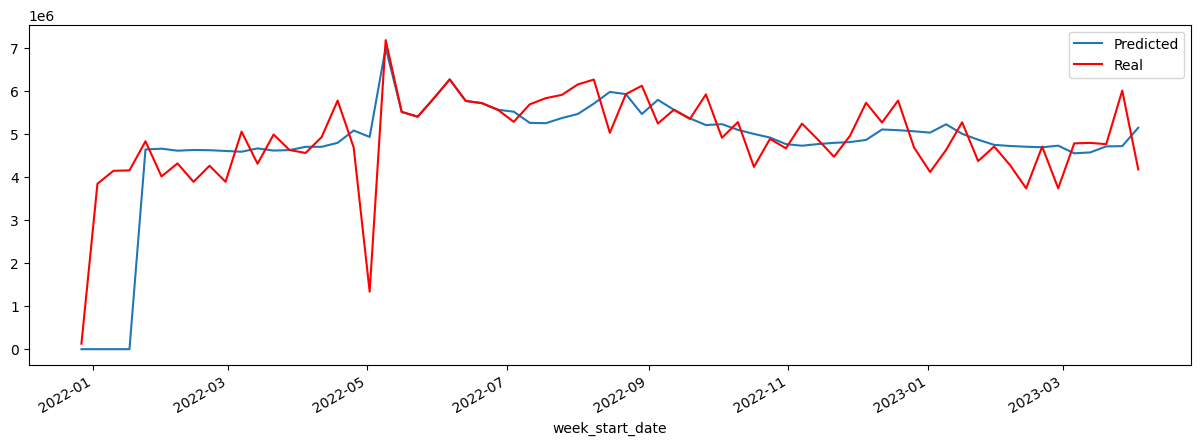

In [515]:
# Trend Visualization between Real Values and Predicted Values

plt.figure(figsize=(15, 5))
plt.plot(sales.index, y_predSVM, label='Predicted')
sales.plot(color='red', label='Real')
plt.legend()

Dari grafik diatas dapat dilihat model prediksi dengan random forest cenderung kurang dapat memprediksi data aktual dengan baik dikarenakan masih adanya selisih dari MAE dan RMSE

## 6.4 Decision Tree Regresor

In [516]:
# Define Decision Tree Regresor
%%time
DTModel = DecisionTreeRegressor(criterion='absolute_error', max_features='auto', max_depth=5)
DTModel.fit(X_trainScaled, y_train)

# Apply Predict
y_predTrainDT = DTModel.predict(X_trainScaled)
y_predTestDT = DTModel.predict(X_testScaled)

# Check MAE
maeTrainDT = round(mean_absolute_error(y_train, y_predTrainDT),2)
rmseTrainDT = round(sqrt(mean_squared_error(y_train, y_predTrainDT)),2)
maeTestDT = round(mean_absolute_error(y_test, y_predTestDT),2)
rmseTestDT = round(sqrt(mean_squared_error(y_test, y_predTestDT)),2)
print('Train - MAE - Decision Tree  : ', maeTrainDT)
print('Train - RMSE - Decision Tree  : ', rmseTrainDT)
print('Test - MAE - Decision Tree   : ', maeTestDT)
print('Test - RMSE - Decision Tree  : ', rmseTestDT)

Train - MAE - Decision Tree  :  178056.46
Train - RMSE - Decision Tree  :  318568.29
Test - MAE - Decision Tree   :  838941.85
Test - RMSE - Decision Tree  :  1095694.24
CPU times: user 8.92 ms, sys: 0 ns, total: 8.92 ms
Wall time: 12.8 ms


Pada model Decision Tree saya menggunakan `criterion = absolute_error` agar model lebih memperhatikan mean_absolute_error, `max_features = auto` dan `max_depth = 5` untuk kedalaman model tree sebanyak 5x split. Setelah model dilatih dengan data train maka didapat nilai MAE terhadap data test sebesar **712451.46** dan RMSE sebesar **873353.22**

In [517]:
# Combine prediction from Decision Tree Regressor
y_predDT = np.concatenate([np.array([0, 0, 0, 0]), y_predTrainDT, y_predTestDT], axis=0)

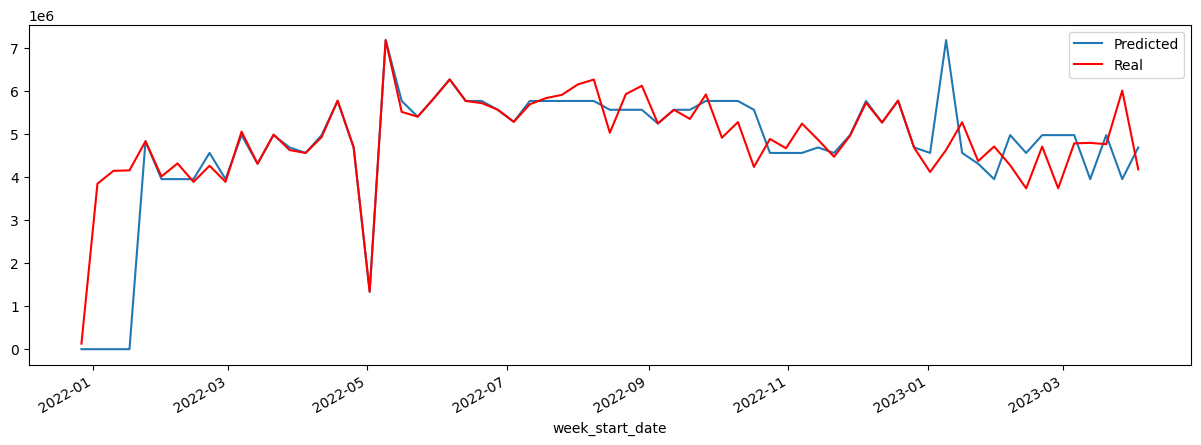

In [518]:
# Trend Visualization between Real Values and Predicted Values

plt.figure(figsize=(15, 5))
plt.plot(sales.index, y_predDT, label='Predicted')
sales.plot(color='red', label='Real')
plt.legend()

Dapat dilihat pada grafik, walaupun model cenderung dapat memprediksi data aktual dengan baik, tapi masih ada gap antara nilai MAE dan RMSE pada data test yang cukup besar

## 6.5 ARIMA

In [519]:
# define dataset for using time-series alogorithm
sales1 = copyData.groupby('week_start_date', as_index=False)['quantity'].sum()
sales1.columns=['Date','Quantity']
sales1.Date=pd.to_datetime(sales1.Date)
sales1.set_index('Date',inplace=True)

In [520]:
# Define data split for arima modeling
train = sales1[:50]
test = sales1[50:]

In [521]:
# Check dataset stationer
def check_stationarity(series):
  
    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [522]:
# Apply function stationer
check_stationarity(sales1['Quantity'])

ADF Statistic: -3.328832
p-value: 0.013638
Critical Values:
	1%: -3.537
	5%: -2.908
	10%: -2.591
Stationary


Karena nilai dari ADF Statistic lebih rendah dibanding dengan nilai 5% dari Critical Value, maka data sudah stationer

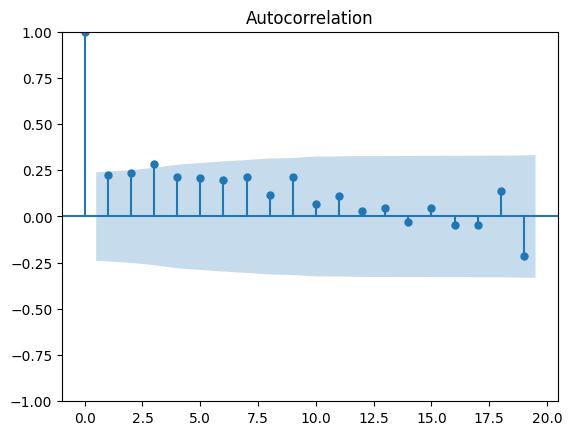

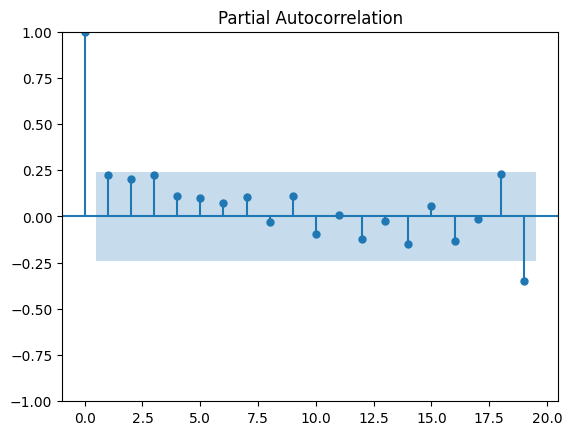

In [523]:
# Ploting ACF and PACF
plot_acf(sales1['Quantity'])
plot_pacf(sales1['Quantity'])
plt.show()

Dapat dilihat dari visualisasi ACF dan PACF diatas, dataset sudah stationer pada lags ke 0 dan sudah berkorelasi pada lags ke 0 pula.

In [524]:
# Define ARIMA model
arima = ARIMA(sales1['Quantity'], order=(0,0,0)) 
arimaModel = arima.fit()
print('The AIC is : ', arimaModel.aic)

The AIC is :  2265.949379103116


In [525]:
# Apply predict using ARIMA
arimaPred = pd.Series(arimaModel.predict(50)[0], index=train.index)
arimaPred = arimaPred.apply(lambda x: '{:.0f}'.format(x))
arimaPred = pd.DataFrame(arimaPred)
arimaPred.columns=['quantity_predict']

# Display
arimaPred

,quantity_predict
Date,
2021-12-27,4893713
2022-01-03,4893713
2022-01-10,4893713
2022-01-17,4893713
2022-01-24,4893713
2022-01-31,4893713
2022-02-07,4893713
2022-02-14,4893713
2022-02-21,4893713


## 6.7 Naive Approach

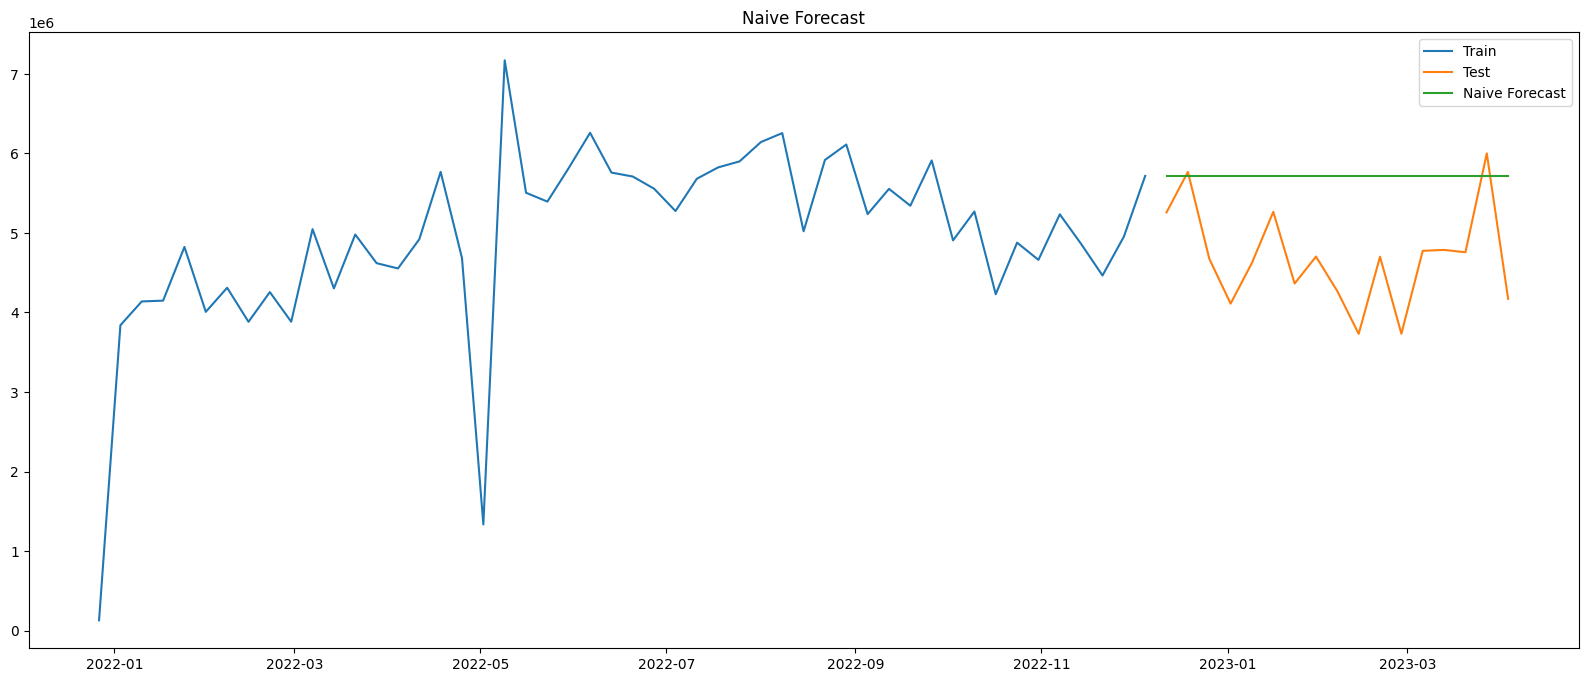

In [526]:
# Define naive approach
dd = np.asarray(train.Quantity)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(20,8))
plt.plot(train.index, train['Quantity'], label='Train')
plt.plot(test.index,test['Quantity'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [527]:
# Find Scoring of naive approach
rmseNaive = round(sqrt(mean_squared_error(test.Quantity, y_hat.naive)),2)
maeNaive = round(mean_absolute_error(test.Quantity, y_hat.naive),2)

print("mae : ", maeNaive)
print("rmse : ", rmseNaive)

mae :  1068829.94
rmse :  1195706.62


Nilai MAE pada Naive Approach masih cukup besar yaitu **1068829.94** dan RMSE sebesar **1195706.62**

## 6.8 Moving Average Forecast

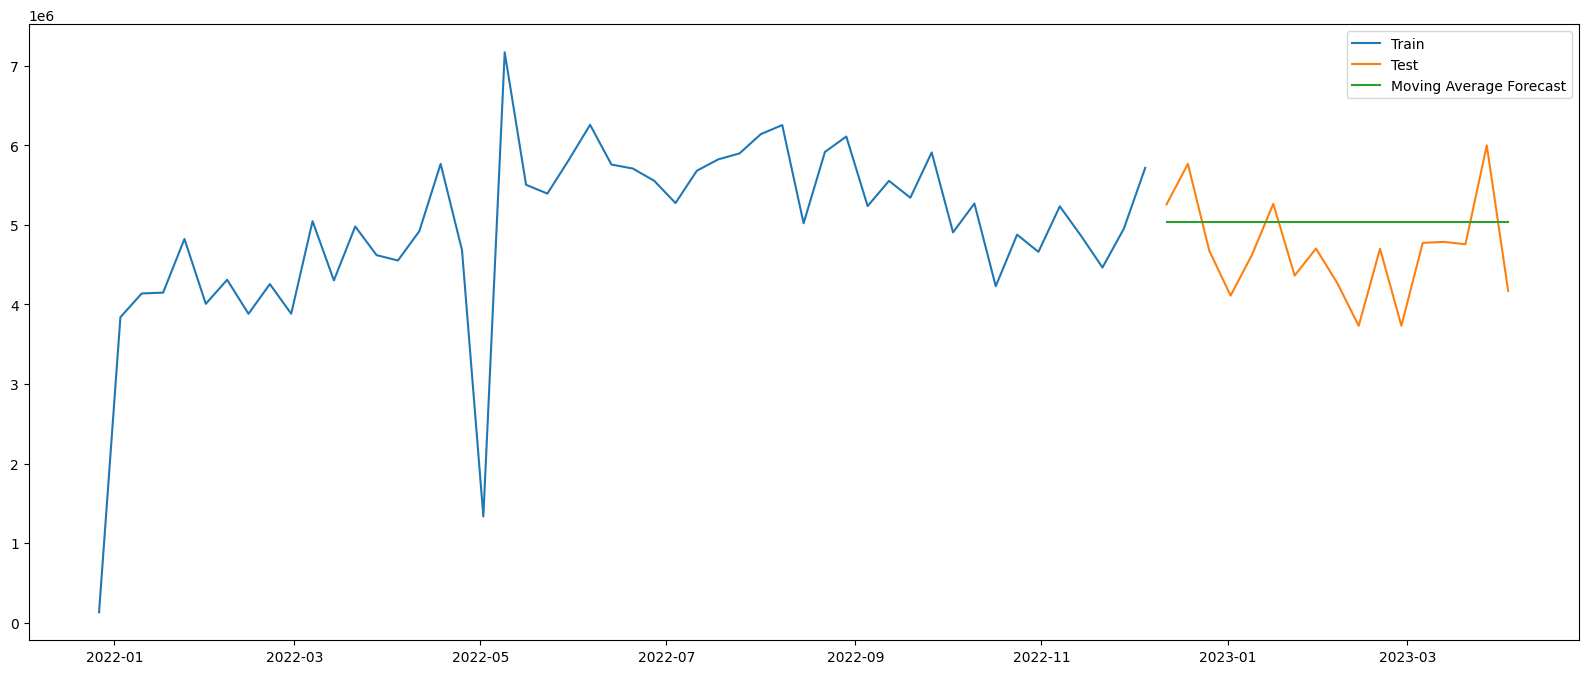

In [528]:
# Define moving average
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train.Quantity.rolling(12).mean().iloc[-1]
plt.figure(figsize=(20,8))
plt.plot(train.Quantity, label='Train')
plt.plot(test.Quantity, label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [529]:
# Find Scoring of moving average
rmseMov = round(sqrt(mean_squared_error(test.Quantity, y_hat_avg.moving_avg_forecast)),2)
maeMov = round(mean_absolute_error(test.Quantity, y_hat_avg.moving_avg_forecast),2)

print("mae : ", maeMov)
print("rmse : ", rmseMov)

mae :  600798.47
rmse :  700556.75


Nilai MAE yang didapat pada model moving average sebesar **600789.47** dan RMSE sebesar **700556.75** dan nilai ini masih lebih baik dibanding dengan naive approach 

## 6.9 Simple Average Forecast

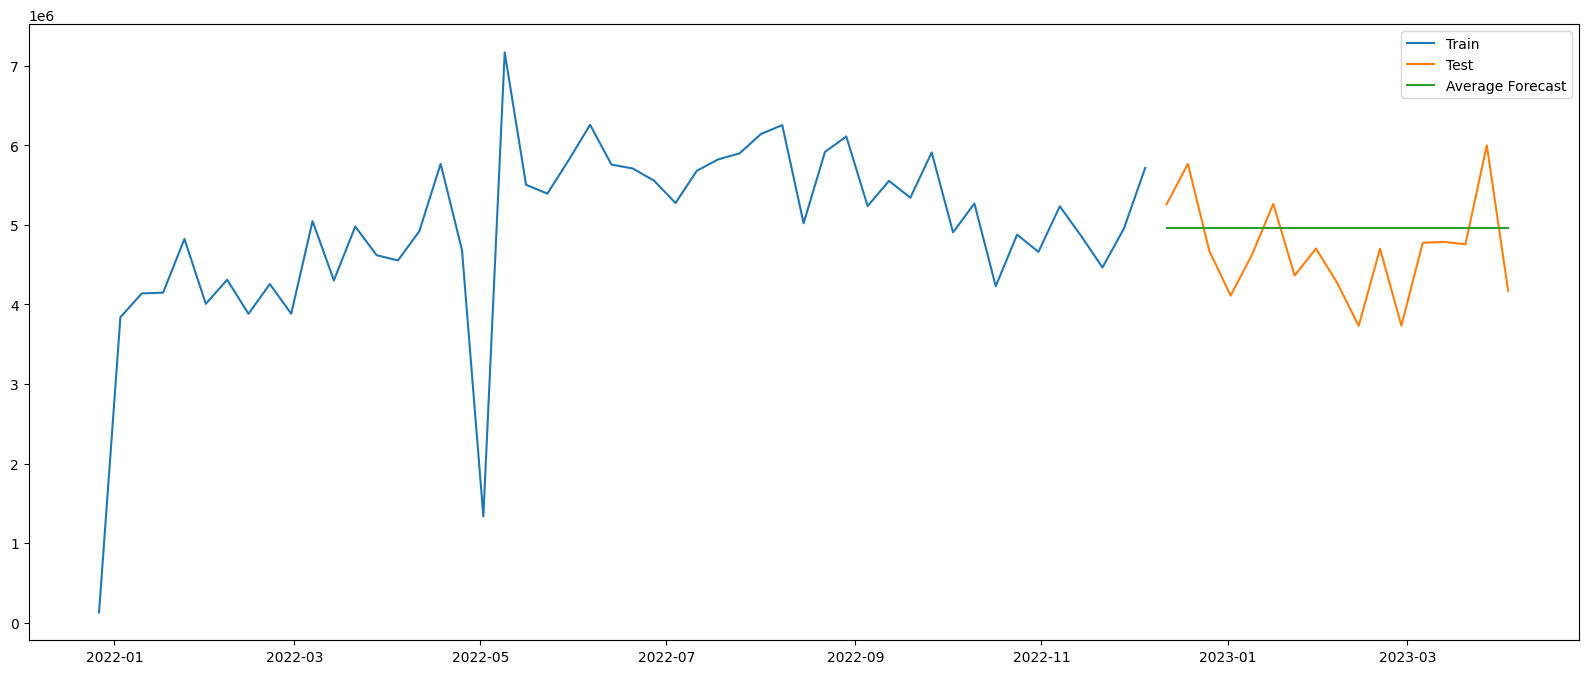

In [530]:
# Define Simple Average
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train.Quantity.mean()
plt.figure(figsize=(20,8))
plt.plot(train.Quantity, label='Train')
plt.plot(test.Quantity, label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()

In [531]:
# Find Scoring of simple average
rmseSA = round(sqrt(mean_squared_error(test.Quantity, y_hat_avg.avg_forecast)),2)
maeSA = round(mean_absolute_error(test.Quantity, y_hat_avg.avg_forecast),2)

print("mae : ", maeSA)
print("rmse : ", rmseSA)

mae :  562289.5
rmse :  667422.7


nilai mae pada simple average masih dibawah dari moving average dengan nilai **562289.5** namun nilai RMSE lebih tinggi dengan nilai **667422.7**

# **7 - Model Evaluation**

---

Pada bagian ini, dilakukan evaluasi model yang harus menunjukkan bagaimana performa model berdasarkan metrics yang dipilih. Hal ini harus dibuktikan dengan visualisasi tren performa dan/atau tingkat kesalahan model. Lakukan analisis terkait dengan hasil pada model dan tuliskan hasil analisisnya.

In [532]:
# Evaluate Model
evaluateDF = pd.DataFrame({
    'Model' : ['Linear Regression', 'Random Forest', 'SVR', 'Decision Tree',
               'Naive Aproach', 'Moving Average', 'Simple Average'],
    'Mean_Absolute_Error' : [maeTestLR, maeTestRF, maeTestSVM, maeTestDT, maeNaive, maeMov, maeSA],
    'RMSE' : [rmseTestLR, rmseTestRF, rmseTestSVM, rmseTestDT, rmseNaive, rmseMov, rmseSA] 
})

# Display
evaluateDF = evaluateDF.sort_values('RMSE', ascending=True)
evaluateDF

,Model,Mean_Absolute_Error,RMSE
2,SVR,505885.36,649890.24
6,Simple Average,562289.50,667422.70
0,Linear Regression,529506.77,670702.74
5,Moving Average,600798.47,700556.75
1,Random Forest,571683.24,727377.79
3,Decision Tree,838941.85,1095694.24
4,Naive Aproach,1068829.94,1195706.62


Dari tabel diatas dapat dilihat untuk nilai MAE dan didukung nilai RMSE model **Support Vector Regresion** menduduki peringkat pertama dengan nilai terendah diantara model yang lain, maka dengan ini saya menggunakan model tersebut untuk digunakan dalam model Inference

# **8 - Model Inference**

---

Model yang sudah dilatih akan dicoba pada data yang bukan termasuk ke dalam train-set ataupun test-set. Data ini harus dalam format yang asli, bukan data yang sudah di-scaled.

In [533]:
# Define function forcasting

def forecasting(week):
    sales_forecast = sales.copy()
    window = 4
    for i in range(week):
        X = np.array(sales_forecast[-window:].values).reshape(1, -1)
        X_scaled = scaler.transform(X)

        # add  7 last day into dataset
        last_date = sales_forecast.index[-1]
        new_date = last_date + pd.Timedelta(days=7)

        # make sure the date are valid
        while True:
            _, last_day = calendar.monthrange(new_date.year, new_date.month)
            if new_date.day <= last_day:
                break
            new_date -= pd.Timedelta(days=1)

        sales_forecast[new_date] = round(SVMModel.predict(X_scaled)[0])

    return sales_forecast

In [534]:
# Display actual data
sales

week_start_date
2021-12-27     128808
2022-01-03    3839557
2022-01-10    4138934
2022-01-17    4149077
2022-01-24    4824273
               ...   
2023-03-06    4775638
2023-03-13    4787111
2023-03-20    4757590
2023-03-27    6001166
2023-04-03    4172070
Name: quantity, Length: 67, dtype: int64

In [535]:
# Forecasting sales for the Next 4 weeks
sales_forecast = forecasting(4)
sales_forecast

week_start_date
2021-12-27     128808
2022-01-03    3839557
2022-01-10    4138934
2022-01-17    4149077
2022-01-24    4824273
               ...   
2023-04-03    4172070
2023-04-10    4838422
2023-04-17    4696809
2023-04-24    4838735
2023-05-01    4707823
Name: quantity, Length: 71, dtype: int64

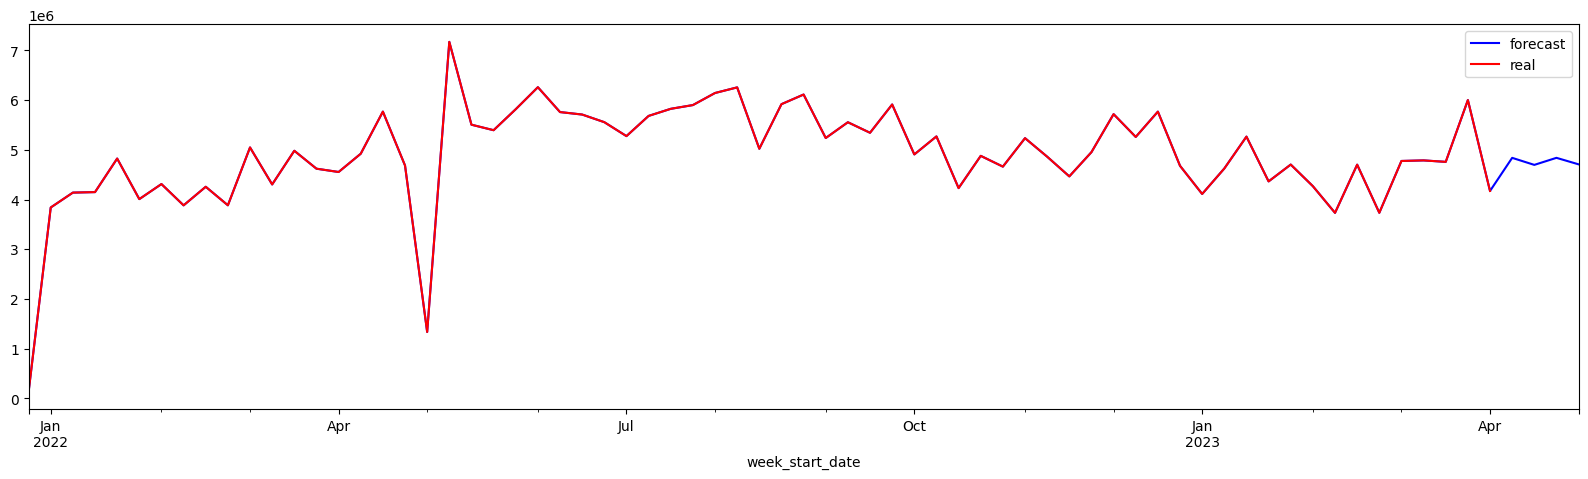

In [536]:
# Displaying forecast
sales_forecast.plot(color='blue',label='forecast',figsize=(20,5))
sales.plot(color='red',label='real')
plt.legend()

In [537]:
# Displaying data forecast
sales_forecast.tail(4)

week_start_date
2023-04-10    4838422
2023-04-17    4696809
2023-04-24    4838735
2023-05-01    4707823
Name: quantity, dtype: int64

# **9 - Model Saving**

---



Pada bagian ini, dilakukan proses penyimpanan model dan file-file lain yang terkait dengan hasil proses pembuatan model.

In [538]:
# Saving the file
with open('Scaling.pkl', 'wb') as file1:
  pickle.dump(scaler, file1)

with open('SVMModel.pkl', 'wb') as file1:
  pickle.dump(SVMModel, file1)

# **10 - Pengambilan Kesimpulan**

---


Pada bagian terakhir ini, harus berisi kesimpulan yang mencerminkan hasil yang didapat dengan objective yang sudah ditulis di bagian pengenalan.

Dari modeling sales forecasting diatas dapat disimpulkan :

1. Model terbaik yang dipilih adalah **Support Vector Regression** karena menghasilkan nilai `mean_absolute_error` senilai **505885.36** dan didukung `root_mean_squared_error` senilai **649890.24**.
2. Dari hasil prediksi dengan menggunakan **Support Vector Regression** maka dari sisi perusahaan dapat mengantisipasi kesalahan prediksi lebih dan kurang sebanyak **505885.36** dari target yang telah ditentukan sebelumnya.
3. Jika nilai prediksi lebih dari aktual, maka untuk target pada pekan selanjutnya sebaiknya dikurangi demi menghindari menumpuknya `product_item` yang belum terjual
4. Jika nilai prediksinya kurang dari aktual, maka sebaiknya perusahaan mengantisipasi dengan menyiapkan produk lebih banyak. 
5. Untuk further improvement, mungkin bisa menggunakan tuning model agar didapatkan nilai `mean_absolute_error` dan `root_mean_squared_error` yang lebih rendah demi menghindari kelebihan stock jika prediksi lebih dari aktual dan kekurangan stok jika ternyata prediksi dibawah dari aktual